In [ ]:
## for google colab

# If encounter google drive issue, remount
# !rm -rf /content/drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!pip install mne ipywidgets ipyevents nibabel trame trame-vtk trame-vuetify pyvista nilearn PyWavelets seaborn statsmodels mne_nirs snirf optuna sktime scikit-learn numpy pandas seaborn

## 1. Load Library

In [ ]:
# Import common libraries
from collections import defaultdict
from copy import deepcopy
from itertools import compress
from pprint import pprint

# Import Plotting Library
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Import StatsModels
import statsmodels.formula.api as smf
from mne import Epochs, events_from_annotations, set_log_level
from mne.preprocessing.nirs import (
    beer_lambert_law,
    optical_density,
    scalp_coupling_index,
    temporal_derivative_distribution_repair,
)

# Import MNE processing
from mne.viz import plot_compare_evokeds


# Import MNE-NIRS processing
from mne_nirs.channels import get_long_channels, picks_pair_to_idx
from mne_nirs.datasets import fnirs_motor_group
from mne_nirs.signal_enhancement import enhance_negative_correlation

# Set general parameters
set_log_level("WARNING")  # Don't show info, as it is repetitive for many subjects
from itertools import compress

import matplotlib.pyplot as plt
import numpy as np
import os
import mne
import snirf

from scipy import signal

## 2. Define function

#### 2.0 Remove close channels

In [ ]:
def remove_close_channels(raw_intensity):
# Remove channels that are too close to each other (less than 1cm)
    picks = mne.pick_types(raw_intensity.info, meg=False, fnirs=True) # [0 ... 111]
    dists = mne.preprocessing.nirs.source_detector_distances(
        raw_intensity.info, picks=picks
    )
    raw_intensity.pick(picks[dists > 0.01]) # Number of channels with distance > 1 cm: 96

    return raw_intensity

#### 2.1 Annotation function

In [ ]:
def process_annotations(raw_intensity):

    # Define wanted stimuli
    wanted_stimulus = ["2", "3"]
    unwanted = np.nonzero(~np.isin(raw_intensity.annotations.description, wanted_stimulus))
    # The ~ operator is used to negate the result of np.isin
    raw_intensity.annotations.delete(unwanted)
    raw_intensity.annotations.rename(
        {"2": "Reappraise", "3": "view negative"}
    )

    return raw_intensity

# Usage:
# raw_intensity = process_annotations(raw_intensity)

#### 2.2 Wavelet motion Correction function

In [ ]:
import numpy as np
import pywt
import mne

def hmr_motion_correct_wavelet_standard(raw_od, iqr=1.5, turnon=1, wavename='db2'):
    if iqr < 0 or turnon == 0:
        return raw_od

    data = raw_od.get_data()
    dod_wavelet = np.zeros_like(data)
    signal_length = data.shape[1]
    n_levels = max(int(np.ceil(np.log2(signal_length))) - 4, 4) # decomposition level, L = 4 is the lowest wavelet scale used in the analysis

    # Identify bad channels
    bads = raw_od.info['bads']
    bad_indices = [raw_od.ch_names.index(bad) for bad in bads if bad in raw_od.ch_names]

    # Determine good channels
    all_indices = set(range(data.shape[0]))
    bad_indices_set = set(bad_indices)
    good_indices = sorted(all_indices - bad_indices_set)

    if not good_indices:
        print("All channels are marked as bad. No motion correction applied.")
        return raw_od.copy()


    for idx, channel_no in enumerate(good_indices):
        # Remove DC component
        dc_val = np.mean(data[channel_no, :])
        data_no_dc = data[channel_no, :] - dc_val

        # Normalize
        med_dev = np.median(np.abs(data_no_dc))
        if med_dev == 0:
            norm_coef = 1
            data_normalized = data_no_dc
        else:
            norm_coef = 1 / (1.4826 * med_dev)
            data_normalized = data_no_dc * norm_coef

        # Wavelet Transform
        coeffs = pywt.wavedec(data_normalized, wavename, mode='periodization', level=n_levels)

        # Thresholding (Artifact Removal)
        for i in range(1, len(coeffs)):
            c = coeffs[i]
            q1, q3 = np.percentile(c, [25, 75])
            iqr_val = q3 - q1
            threshold = iqr * iqr_val
            coeffs[i] = np.where((c > (q3 + threshold)) | (c < (q1 - threshold)), 0, c) # np.where(condition, value if true, value if false)

        # Inverse Wavelet Transform
        reconstructed = pywt.waverec(coeffs, wavename, mode='periodization')

        # Denormalize and add DC component
        reconstructed = reconstructed / norm_coef + dc_val

        # Truncate to original signal length
        dod_wavelet[channel_no, :] = reconstructed[:signal_length]

    # For bad channels, retain the original data
    if bad_indices:
        dod_wavelet[bad_indices, :] = data[bad_indices, :]
        print(f"Retained original data for {len(bad_indices)} bad channels.")

    raw_od_corrected = mne.io.RawArray(dod_wavelet, raw_od.info)
    return raw_od_corrected

#### 2.3 hmr_Bandpass_Filter function
(Auxiliary --> accelerometer/gyroscope data).
Both optical density and auxiliary data uses the same bandpass filter function

In [ ]:
def hmr_Bandpass_Filter(data, hpf=0.01, lpf=0.4):
    fs = data.info["sfreq"] # sampling frequency = 5.09 Hz
    if hpf > (fs/2) or lpf > (fs/2): # if bandpass filter > nyquist frequency
        print("Warning: Bandpass filter is larger than the Nyquist frequency")
        return data

    # Get the data array
    x = data.get_data()
    filtered_data = x.copy()

    # low-pass filter
    lpf_norm = lpf / (fs/2) #  The normalized lpf_norm = 0.157 indicates that the low-pass cutoff is at 15.7% of the Nyquist frequency.
    if lpf_norm > 0:
        # Create filter
        filter_order = 3
        # Design an 3rd-order digital Butterworth filter and return the filter coefficients.
        b, a = signal.butter(filter_order, lpf_norm, 'low')  # butter(N, Wn, btype='low')
            # N: The order of the filter
            # For digital filters, if fs is not specified, Wn units are normalized from 0 to 1, where 1 is the Nyquist frequency (Wn is thus in half cycles / sample and defined as 2*critical frequencies / fs). If fs is specified, Wn is in the same units as fs.
            # btype {‘lowpass’, ‘highpass’, ‘bandpass’, ‘bandstop’}, optional, The type of filter. Default is ‘lowpass’.

        for ch in range(x.shape[0]):
            filtered_data[ch, :] = signal.filtfilt(b, a, filtered_data[ch, :]) # b : The numerator coefficient vector; a : The denominator coefficient vector

    # High-pass filter
    hpf_norm = hpf / (fs/2)
    if hpf_norm > 0:
        filter_order_h = 5
        b_h, a_h = signal.butter(filter_order_h,hpf_norm, 'high')
        for ch in range(x.shape[0]):
            filtered_data[ch, :] = signal.filtfilt(b_h, a_h, filtered_data[ch, :])

    data_filtered = data.copy()
    data_filtered._data = filtered_data

    return data_filtered




#### 2.4 Define MotionCorrectCbsi function

This function assumes that the true psychological signals of HbO and HbR are negatively correlated

Page 5 of https://doi.org/10.3390/s23083979

In [ ]:
def hmrR_MotionCorrectCbsi(raw_haemo):

    hbo_channels = [ch for ch in raw_haemo.ch_names if 'hbo' in ch.lower()]
    hbr_channels = [ch for ch in raw_haemo.ch_names if 'hbr' in ch.lower()]

    hbo_indices = [idx for idx, ch in enumerate(raw_haemo.ch_names) if 'hbo' in ch.lower()] # [0-47]
    hbr_indices = [idx for idx, ch in enumerate(raw_haemo.ch_names) if 'hbr' in ch.lower()] #[48-95]

    haemo_data = raw_haemo.get_data() # (96, 2396)
    n_timepoints = haemo_data.shape[1] # 2396
    n_channels = len(hbo_channels) # 48

    data_dc = np.zeros((n_timepoints, 3 ,n_channels)) # (2396, 3, 48)
    data_dc[:,0,:] = haemo_data[hbo_indices,:].T
    data_dc[:,1,:] = haemo_data[hbr_indices,:].T

    # avoid changing original data
    dc = data_dc.copy()

    # Copy data for correction
    dcCbsi = dc.copy()

    for idx_ch in range(n_channels):

        # Mean-center the HbO and HbR signals
        dc_oxy = dc[:, 0, idx_ch] - np.mean(dc[:, 0, idx_ch])
        dc_deoxy = dc[:, 1, idx_ch] - np.mean(dc[:, 1, idx_ch])

        # Calculate standard deviations
        sd_oxy = np.std(dc_oxy, ddof=0) #Delta Degrees of Freedom = 0: divides by n
        sd_deoxy = np.std(dc_deoxy, ddof=0)

        # Compute alpha, avoiding division by zero
        if sd_deoxy != 0:
            alfa = sd_oxy / sd_deoxy
        else:
            alfa = 0

        # Apply CBSI correction
        dcCbsi[:, 0, idx_ch] = 0.5 * (dc_oxy - alfa * dc_deoxy)
        if alfa != 0:
            dcCbsi[:, 1, idx_ch] = - (1 / alfa) * dcCbsi[:, 0, idx_ch]
        else:
            dcCbsi[:, 1, idx_ch] = 0  # Handle division by zero

        dcCbsi[:, 2, idx_ch] = dcCbsi[:, 0, idx_ch] + dcCbsi[:, 1, idx_ch]

    raw_copy = raw_haemo.copy()

    # Step 4: Extract and replace HbO and HbR data
    corrected_hbo = dcCbsi[:, 0, :].T  # Shape: (n_channels, n_timepoints)
    corrected_hbr = dcCbsi[:, 1, :].T  # Shape: (n_channels, n_timepoints)

    # Replace data in-place
    raw_copy._data[hbo_indices, :] = corrected_hbo
    raw_copy._data[hbr_indices, :] = corrected_hbr

    # Step 5: Add HbT channels
    corrected_hbt = dcCbsi[:, 2, :].T  # Shape: (n_channels, n_timepoints)

    # Define HbT channel names
    hbt_channels = [ch.replace('hbo', 'hbt') for ch in hbo_channels]

    # Define channel types for HbT
    hbt_channel_types = ['misc'] * n_channels  # 'misc' since 'hbt' is not standard in MNE

    # Create Info object for HbT channels
    hbt_info = mne.create_info(ch_names=hbt_channels, sfreq=raw_copy.info['sfreq'], ch_types=hbt_channel_types)

    # Create RawArray for HbT channels
    raw_hbt = mne.io.RawArray(corrected_hbt, hbt_info)

    # Add HbT channels to the Raw copy
    raw_copy.add_channels([raw_hbt], force_update_info=True)

    return raw_copy

#### 2.5 Define get ROI channel function

take away 'hbr' data to reduce redundancy

In [ ]:
def get_ROI_channels(raw_copy):
    # Get channel names from your fNIRS dataset
    channel_names = raw_copy.ch_names

    # Define the selection criteria
    selection_criteria = ['S2', 'S4', 'S5', 'S6']

    # Create a list to store selected channel names
    selected_channels = []

    for channel in channel_names:
        if any(criterion in channel for criterion in selection_criteria) and ('hbo' in channel or 'hbr' in channel or 'hbt' in channel): #HbO channels: 760nm HbR channels: 850nm
            selected_channels.append(channel)

    # Now, get the indices of these selected channels
    picks = [channel_names.index(name) for name in selected_channels]

    return picks

#### 2.6 Define get evoked metadata for Reappraise / view negative

In [ ]:
def get_evoked_metadata(raw_copy, events, event_dict, picks):
    # Rejection criteria for bad epochs
    reject_criteria = dict(hbo=100e-7)

    epochs = mne.Epochs(raw_copy,
                       events,
                       event_id=event_dict,
                       tmin=-2,
                       tmax=20,
                       picks=picks,
                       baseline= (None, 0),# None,
                       reject=reject_criteria,
                       preload=True,
                       verbose=False)

    # Get rejected epochs information
    drop_log = epochs.drop_log
    dropped_indices = [i for i, drops in enumerate(drop_log) if drops]

    print(f"\nNumber of rejected epochs: {len(dropped_indices)}")
    print("\nRejected epochs event types:")
    for i in dropped_indices:
        event_type = events[i][2]
        print(f"Epoch {i}: Event type {event_type}")


    # Separate epochs by condition and channel type
    epochs_dict = {
        "Reappraise": {
            "HbO": epochs["Reappraise"].get_data(picks="hbo"),

        },
        "view_negative": {
            "HbO": epochs["view negative"].get_data(picks="hbo"),
        }
    }

    # Get channel names for each type
    hbo_ch_names = [ch for ch in epochs.ch_names if 'hbo' in ch.lower()]


    # Remove frequency encoding from channel names
    hbo_ch_names = [ch[:-4] for ch in hbo_ch_names]


    # Create metadata DataFrames
    metadata_df_reappraise = pd.DataFrame({
        'epoch': range(len(epochs["Reappraise"])),
        'condition': 'Reappraise',
        'times': [epochs.times] * len(epochs["Reappraise"]),
        'hbo_ch_names': [hbo_ch_names] * len(epochs["Reappraise"]),
    })

    metadata_df_view_negative = pd.DataFrame({
        'epoch': range(len(epochs["view negative"])),
        'condition': 'view_negative',
        'times': [epochs.times] * len(epochs["view negative"]),
        'hbo_ch_names': [hbo_ch_names] * len(epochs["view negative"]),
    })

    return epochs_dict, metadata_df_reappraise, metadata_df_view_negative, epochs.times

#### 2.7 Define interpolation function

In [ ]:
# identifies bad fNIRS channels via scalp coupling index, interpolates them
def interpolate_bad_channels(raw_od, sci_value):
    # Make a copy for preprocessing
    raw_od_copy = raw_od.copy()

    # Set montage
    montage = raw_od_copy.get_montage()
    raw_od_copy.set_montage(montage)

    # Calculate scalp coupling index
    sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od_copy)

    # Mark bad channels based on SCI
    raw_od_copy.info["bads"] = list(compress(raw_od_copy.ch_names, sci < sci_value))
    # Interpolate bad channels
    raw_od_copy.interpolate_bads(
        reset_bads=False,      # Keep bad channels in the bads list after interpolation
        mode='accurate',       # Use high-quality interpolation
        method="nearest"       # Specify interpolation method for fNIRS channels
    )
    # Create a RawArray with processed data and original info
    processed_data = raw_od_copy.get_data()
    original_info = raw_od.info.copy()

    # Create new Raw object
    raw_od = mne.io.RawArray(processed_data, original_info)

    return raw_od

## 3. Subject Level Analysis

Each person has 12 metadata, every metadata is a 2D matrix of shape {39 channels [HbO, HbR, HbT], 113 timepoints [-2 to 20s]}

In [ ]:
import os
import mne
import numpy as np
from glob import glob
import mne_nirs
import logging  # Import the logging module

import warnings

# Suppress specific RuntimeWarning about missing nasion
warnings.filterwarnings("ignore",message="Fiducial point nasion not found, assuming identity unknown to head transformation",category=RuntimeWarning)

# Suppress specific RuntimeWarning about no bad channels to interpolate
warnings.filterwarnings("ignore",message="No bad channels to interpolate. Doing nothing...",category=RuntimeWarning)

PARTICIPANT_CHANNELS = {
1: 'S6_D4', 2: 'S2_D2', 3: 'S2_D3', 4: 'S2_D4', 5: 'S4_D6',
6: 'S6_D7', 7: 'S6_D4', 8: 'S4_D6', 9: 'S5_D3', 10: 'S4_D4',
11: 'S4_D4', 12: 'S5_D4', 13: 'S2_D2', 14: 'S1_D2', 15: 'S5_D3',
16: 'S4_D2', 17: 'S6_D4', 18: 'S6_D6', 19: 'S4_D6', 20: 'S1_D2',
21: 'S5_D4', 22: 'S1_D2', 23: 'S2_D4', 24: 'S6_D4', 25: 'S6_D4',
26: 'S6_D4', 27: 'S2_D4', 28: 'S6_D6', 29: 'S4_D6', 30: 'S2_D4',
31: 'S6_D4', 32: 'S5_D7', 33: 'S6_D4', 34: 'S4_D6', 35: 'S6_D4',
36: 'S6_D7', 37: 'S4_D4', 38: 'S2_D4', 39: 'S4_D6', 40: 'S6_D4',
41: 'S4_D2', 42: 'S2_D4', 43: 'S4_D4', 44: 'S4_D4', 45: 'S5_D3',
46: 'S6_D4', 47: 'S4_D6', 48: 'S4_D2', 49: 'S4_D4', 50: 'S4_D6',
51: 'S4_D6', 52: 'S4_D6', 53: 'S4_D2', 54: 'S6_D4', 55: 'S4_D2',
56: 'S6_D6', 57: 'S4_D2'
}

PARTICIPANT_CHANNELS_2 = {
    1: 'S6_D6', 2: 'S1_D2', 3: 'S6_D7', 4: 'S2_D3', 5: 'S6_D6',
    6: 'S6_D4', 7: 'S6_D6', 8: 'S5_D3', 9: 'S5_D7', 10: 'S6_D4',
    11: 'S4_D6', 12: 'S5_D3', 13: 'S4_D2', 14: 'S4_D4', 15: 'S5_D7',
    16: 'S6_D4', 17: 'S4_D4', 18: 'S6_D4', 19: 'S6_D6', 20: 'S2_D2',
    21: 'S2_D4', 22: 'S2_D4', 23: 'S5_D4', 24: 'S2_D4', 25: 'S6_D7',
    26: 'S4_D4', 27: 'S4_D4', 28: 'S4_D6', 29: 'S4_D4', 30: 'S2_D4',
    31: 'S6_D7', 32: 'S5_D3', 33: 'S6_D6', 34: 'S4_D2', 35: 'S6_D6',
    36: 'S5_D7', 37: 'S5_D3', 38: 'S4_D4', 39: 'S6_D4', 40: 'S4_D6',
    41: 'S4_D4', 42: 'S2_D3', 43: 'S4_D6', 44: 'S6_D4', 45: 'S5_D7',
    46: 'S6_D6', 47: 'S6_D6', 48: 'S4_D4', 49: 'S5_D4', 50: 'S6_D4',
    51: 'S6_D4', 52: 'S4_D4', 53: 'S4_D6', 54: 'S5_D4', 55: 'S6_D4',
    56: 'S4_D6', 57: 'S4_D4'
}

Best_performing_channels = {
1: 'S6_D4', 2: 'S2_D2', 3: 'S6_D7', 4: 'S2_D4', 5: 'S4_D6',
6: 'S6_D4', 7: 'S6_D4', 8: 'S5_D3', 9: 'S5_D7', 10: 'S6_D4',
11: 'S4_D6', 12: 'S5_D3', 13: 'S2_D2', 14: 'S1_D2', 15: 'S5_D3',
16: 'S4_D2', 17: 'S4_D4', 18: 'S6_D4', 19: 'S4_D6', 20: 'S2_D2',
21: 'S5_D4', 22: 'S2_D4', 23: 'S2_D4', 24: 'S4_D4', 25: 'S4_D4',
26: 'S6_D4', 27: 'S2_D4', 28: 'S6_D6', 29: 'S4_D6', 30: 'S2_D4',
31: 'S6_D4', 32: 'S5_D7', 33: 'S6_D6', 34: 'S4_D6', 35: 'S6_D4',
36: 'S6_D7', 37: 'S5_D3', 38: 'S4_D4', 39: 'S4_D6', 40: 'S6_D4',
41: 'S4_D2', 42: 'S2_D4', 43: 'S4_D4', 44: 'S4_D4', 45: 'S5_D3',
46: 'S6_D4', 47: 'S4_D6', 48: 'S4_D2', 49: 'S4_D4', 50: 'S6_D4',
51: 'S4_D6', 52: 'S4_D6', 53: 'S4_D2', 54: 'S6_D4', 55: 'S4_D2',
56: 'S6_D6', 57: 'S4_D2'
}

base_dir = r"/content/drive/MyDrive/fNIRS data/neurofeedback" # google colab: r"/content/drive/MyDrive/fNIRS data/neurofeedback"
participant_id = 24 # For participant p01

def subject_wise_analysis_1_to_6(base_dir, participant_id, ROI=True):

    """
    Process fNIRS data for a given participant across multiple runs.

    Parameters:
    - base_dir (str): Base directory containing participant data.
    - participant_id (int): Participant identifier.

    Returns:
    - all_run_results (list): List of dictionaries containing run data.
    """

    participant_dir = os.path.join(base_dir, f"p{participant_id:02d}") # 0 means add zeros if needed # 2 specifies a minimum field width of 2 characters # d indicates that the valueshould be formatted as a decimal integer(base-10 number system)

    # Find all directories that have at least one underscore in their name
    date_dirs = glob(os.path.join(participant_dir, "????-??-??_???")) # ['C:\\Users\\user\\Desktop\\fNIRS data\\p01\\2024-08-09_001', 'C:\\Users\\user\\Desktop\\fNIRS data\\p01\\2024-08-09_002', 'C:\\Users\\user\\Desktop\\fNIRS data\\p01\\2024-08-09_003', 'C:\\Users\\user\\Desktop\\fNIRS data\\p01\\2024-08-09_004', 'C:\\Users\\user\\Desktop\\fNIRS data\\p01\\2024-08-09_005', 'C:\\Users\\user\\Desktop\\fNIRS data\\p01\\2024-08-09_006']
    # glob : find all file system paths matching a specified pattern
    # the pattern "*_*": * indicates any number of characters, _ matches an underscore,
    if not date_dirs:
        print(f"No data directories found for participant {participant_id}")
        return None

    target_channel = PARTICIPANT_CHANNELS[participant_id]

    target_channel_2 = PARTICIPANT_CHANNELS_2[participant_id]

    target_channel_3 = Best_performing_channels[participant_id]

    # create a dictionary to store HbO data from different runs
    all_epochs_dict = {
    'neuro_train_1': {"Reappraise_HbO": []},
    'neuro_train_2': {"Reappraise_HbO": []},
    'neuro_train_3': {"Reappraise_HbO": []},
    'neuro_train_4': {"Reappraise_HbO": []}
    }

    # Extract run numbers and create a dictionary mapping run numbers to full paths
    run_dict = {int(run[-3:]): run for run in date_dirs}

    # Sort run numbers
    all_runs = sorted(run_dict.keys())

    # Get middle runs (exclude first and last)
    neurofeedback_training = all_runs[1:-1]

    # Create list of selected runs in order
    selected_runs = [run_dict[run_num] for run_num in neurofeedback_training]

    for idx, run in enumerate(selected_runs):

        run_name = f'neuro_train_{idx+1}'
        # print(f"\nProcessing Run {run[-3:]} for participant {participant_id} as {run_name}")  # Gets last 3 characters (e.g., '001')
        snirf_files = glob(os.path.join(run,"*.snirf"))

        if not snirf_files:
            print(f"No SNIRF file found in {run}")
            continue

        fnirs_snirf = snirf_files[0]  # Take the first (and hopefully only) SNIRF file

        # Load raw intensity info from .snirf file
        raw_intensity = mne.io.read_raw_snirf(fnirs_snirf, preload=True)
        raw_intensity.load_data()

         # montage is a description of the sensor positionin 3D space

        # drop unwanted events (only leave 2 and 3), and annotate event names
        raw_intensity = process_annotations(raw_intensity)

        # Remove channels that are too close to each other (less than 1cm)
        raw_intensity = remove_close_channels(raw_intensity)

        # Convert signal to optical density
        raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)

        # identifies bad fNIRS channels via scalp coupling index, interpolates them
        raw_od = interpolate_bad_channels(raw_od, sci_value = 0.9)

        # Motion Correction Wavelet
        raw_od_wavelet = hmr_motion_correct_wavelet_standard(raw_od, iqr=1.5, turnon=1, wavename='db2')

        # Apply Bandpass Filter
        raw_od_wavelet_filtered = hmr_Bandpass_Filter(raw_od_wavelet, hpf=0.01, lpf=0.4)

        # Convert to haemoglobin, and apply further data cleaning techniques
        raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od_wavelet_filtered, ppf=6.0) # default in Homer

        # Apply Motion Correct Cbsi
        raw_copy = hmrR_MotionCorrectCbsi(raw_haemo) # OR use library function: mne_nirs.signal_enhancement.enhance_negative_correlation(raw_haemo)

        target_channel_hbo = f"{target_channel} hbo" # HbO = 760nm
        target_channel_hbo_2 = f"{target_channel_2} hbo"
        target_channel_hbo_3 = f"{target_channel_3} hbo"

        # Get channel index
        ch_idx = raw_copy.ch_names.index(target_channel_hbo)
        ch_idx_2 = raw_copy.ch_names.index(target_channel_hbo_2)
        ch_idx_3 = raw_copy.ch_names.index(target_channel_hbo_3)

        # Find event epochs (8 view_negative / 8 reappraise)
        events, event_dict = mne.events_from_annotations(raw_intensity)

        epochs_dict, metadata_df_reappraise, metadata_df_view_negative, epochs_times = get_evoked_metadata(raw_copy, events, event_dict, picks=[ch_idx_3])  # picks=[ch_idx, ch_idx_2]

        reappraise_data = epochs_dict["Reappraise"]["HbO"] # Shape: (8, 1, 113)

        # Debug print to see the shape of reappraise_data
        # print(f"Raw reappraise data shape: {reappraise_data.shape}")

        # mean_data_ch1 = np.mean(reappraise_data[:, 0, :], axis=(0, 1))  # First channel
        # mean_data_ch2 = np.mean(reappraise_data[:, 1, :], axis=(0, 1))  # Second channel

        mean_data = np.mean(reappraise_data, axis=(0, 2)) # return a single value across epochs and timepoints
        # mean_data = np.mean([mean_data_ch1, mean_data_ch2], axis=0)

        #if np.isscalar(mean_data):
        #      mean_data = np.array([mean_data])  # Convert scalar to 1D array
        # print(f"mean reappraise data shape: {mean_data.shape}")
        # Store only Reappraise HbO data for this specific run
        all_epochs_dict[run_name]["Reappraise_HbO"] = mean_data

        print(f"Participant {participant_id} - {run_name} - {target_channel_3}: "
              f"Value = {all_epochs_dict[run_name]['Reappraise_HbO']}")
    '''
        # After each major preprocessing step
    print("After OD conversion:")
    print(raw_od.get_data().mean())

    print("After wavelet:")
    print(raw_od_wavelet.get_data().mean())

    print("After filtering:")
    print(raw_od_wavelet_filtered.get_data().mean())

    print("After Beer-Lambert:")
    print(raw_haemo.get_data().mean())

    print("After CBSI:")
    print(raw_copy.get_data().mean())
    '''
    return all_epochs_dict, epochs_times, target_channel

In [ ]:
all_epochs_dict, epochs_time, hbo_ch_names =subject_wise_analysis_1_to_6(base_dir, participant_id, ROI=True)



Number of rejected epochs: 0

Rejected epochs event types:
Participant 24 - neuro_train_1 - S4_D4: Value = [2.32188288e-07]

Number of rejected epochs: 0

Rejected epochs event types:
Participant 24 - neuro_train_2 - S4_D4: Value = [-1.604453e-07]

Number of rejected epochs: 0

Rejected epochs event types:
Participant 24 - neuro_train_3 - S4_D4: Value = [1.90023256e-07]

Number of rejected epochs: 0

Rejected epochs event types:
Participant 24 - neuro_train_4 - S4_D4: Value = [1.51848579e-07]


In [ ]:
print(all_epochs_dict)

{'neuro_train_1': {'Reappraise_HbO': array([2.32188288e-07])}, 'neuro_train_2': {'Reappraise_HbO': array([-1.604453e-07])}, 'neuro_train_3': {'Reappraise_HbO': array([1.90023256e-07])}, 'neuro_train_4': {'Reappraise_HbO': array([1.51848579e-07])}}


## 4. get all participants' data

1. If a channel is bad in any run, it might be unreliable in other runs too
2. For group analysis, we need consistent channel layouts across all runs
3. So, we remove channels marked as bad in any run from all runs

In [ ]:
import numpy as np
from scipy import stats  # Add this import
import matplotlib.pyplot as plt
import seaborn as sns

def process_fnirs_data():

    # We reject participant's data if the negativity reaponse pattern happens to be "invariant responding", which is a clear indicator of low-quality data

    base_dir = r"/content/drive/MyDrive/fNIRS data/neurofeedback" # google colab: r"/content/drive/MyDrive/fNIRS data/neurofeedback"
    participant_ids= [1,3,6,7,10,11,13,15,16,17,20,21,24,28,30,31,33,37,38,40,41,43,45,46,48,50,55,56] # google colab: [1,3,6,7,8,10,11,13,15,16,17,20,21,24,28,30,31,33,37,38,40,41,43,45]
      # reject p8 as 51/63 responses are 1s (79.7%), 13/64 responses are 2s

    # Initialize group-level epochs dictionary
    group_epochs_dict = {
    'neuro_train_1': {"Reappraise_HbO": []}, # [] is an empty list
    'neuro_train_2': {"Reappraise_HbO": []},
    'neuro_train_3': {"Reappraise_HbO": []},
    'neuro_train_4': {"Reappraise_HbO": []}
    }

    for participant_id in participant_ids:
        print(f"\nProcessing participant {participant_id}")

        participant_epochs,_,_=subject_wise_analysis_1_to_6(base_dir, participant_id, ROI=True)

        for condition in group_epochs_dict:
                if participant_epochs[condition]['Reappraise_HbO'].size > 0:  # Check if there's data
                    # Use append instead of extend for single float values
                    group_epochs_dict[condition]['Reappraise_HbO'].append(
                    float(participant_epochs[condition]['Reappraise_HbO'][0])) # add value to the list one by one

    # Convert lists to numpy arrays for analysis
    for run in group_epochs_dict:
        group_epochs_dict[run]['Reappraise_HbO'] = np.array(group_epochs_dict[run]['Reappraise_HbO'])

    return group_epochs_dict

group_epochs_dict = process_fnirs_data()

'''
    # Prepare data for statistical analysis
    run_data = {}
    for run in group_epochs_dict:
        run_data[run] = group_epochs_dict[run]['Reappraise_HbO']

    # Calculate descriptive statistics
    descriptive_stats = {
        run: {
            'mean': np.mean(data),
            'std': np.std(data),
            'sem': stats.sem(data),
            'n': len(data)
        } for run, data in run_data.items()
    }
'''


Processing participant 1

Number of rejected epochs: 0

Rejected epochs event types:
Participant 1 - neuro_train_1 - S6_D4: Value = [-3.78726059e-08]

Number of rejected epochs: 0

Rejected epochs event types:
Participant 1 - neuro_train_2 - S6_D4: Value = [7.77013317e-08]

Number of rejected epochs: 0

Rejected epochs event types:
Participant 1 - neuro_train_3 - S6_D4: Value = [3.22559836e-07]

Number of rejected epochs: 0

Rejected epochs event types:
Participant 1 - neuro_train_4 - S6_D4: Value = [1.46395204e-07]

Processing participant 3

Number of rejected epochs: 0

Rejected epochs event types:
Participant 3 - neuro_train_1 - S6_D7: Value = [1.8322683e-07]

Number of rejected epochs: 0

Rejected epochs event types:
Participant 3 - neuro_train_2 - S6_D7: Value = [6.14221125e-08]

Number of rejected epochs: 0

Rejected epochs event types:
Participant 3 - neuro_train_3 - S6_D7: Value = [9.45254586e-08]

Number of rejected epochs: 0

Rejected epochs event types:
Participant 3 - neur

"\n    # Prepare data for statistical analysis\n    run_data = {}\n    for run in group_epochs_dict:\n        run_data[run] = group_epochs_dict[run]['Reappraise_HbO']\n\n    # Calculate descriptive statistics\n    descriptive_stats = {\n        run: {\n            'mean': np.mean(data),\n            'std': np.std(data),\n            'sem': stats.sem(data),\n            'n': len(data)\n        } for run, data in run_data.items()\n    }\n"

In [ ]:
group_epochs_dict

{'neuro_train_1': {'Reappraise_HbO': array([-3.78726059e-08,  1.83226830e-07,  1.58709719e-07,  6.58295807e-08,
          3.12040152e-07, -2.29434484e-09,  4.77724270e-08, -1.83026292e-07,
          1.09527304e-08,  3.32975907e-08, -3.58006270e-08, -5.37600544e-08,
          2.32188288e-07,  1.63662449e-07, -6.60366552e-09,  1.88317065e-07,
          2.85747796e-08, -8.81756075e-08,  6.80935733e-08, -8.45823157e-08,
          1.63716676e-08,  3.89163437e-08,  3.82575725e-08,  2.78690457e-08,
         -1.88864800e-07,  3.56575526e-08,  9.84402628e-08,  5.73639609e-08])},
 'neuro_train_2': {'Reappraise_HbO': array([ 7.77013317e-08,  6.14221125e-08,  2.42907038e-08,  7.74916611e-08,
          6.39559915e-08, -7.96602807e-08, -1.69895380e-08, -5.02427174e-09,
         -7.65094859e-08,  1.55508931e-08,  4.81146047e-08, -6.24528445e-08,
         -1.60445300e-07,  1.59287847e-07, -2.33090173e-07,  1.03722622e-07,
          5.77818024e-08, -7.12336224e-08, -2.64793025e-08, -5.33347518e-08,
   

## 5. Perform repeated-measure ANOVA

In [ ]:
from statsmodels.stats.anova import AnovaRM

def perform_repeated_anova(group_epochs_dict):

    total_participants = len(group_epochs_dict['neuro_train_1']['Reappraise_HbO'])

    total_runs = ['neuro_train_1', 'neuro_train_2', 'neuro_train_3', 'neuro_train_4']
    all_subjects_data = []
    for participant_id in range(total_participants):
        subject_data = []
        for current_run_name in total_runs:
              run_number = current_run_name[-1]
              hbo_value = group_epochs_dict[current_run_name]['Reappraise_HbO'][participant_id]
              subject_data.append({
                  'Subject': participant_id + 1,
                  'Run': run_number,
                  'HbO': hbo_value
              })
        all_subjects_data.extend(subject_data)
    # For each subject's data in each run

    # Convert to DataFrame
    df_long = pd.DataFrame(all_subjects_data)

    print("First few rows (showing first subject across all runs):")
    print(df_long.head(4))

    # Perform repeated measures ANOVA
    aovrm = AnovaRM(data=df_long, depvar='HbO', subject='Subject', within=['Run'])
    result = aovrm.fit()

    # Print results
    print("\nANOVA Results:")
    print(result.summary())

    return result, df_long

result, df = perform_repeated_anova(group_epochs_dict)

First few rows (showing first subject across all runs):
   Subject Run           HbO
0        1   1 -3.787261e-08
1        1   2  7.770133e-08
2        1   3  3.225598e-07
3        1   4  1.463952e-07

ANOVA Results:
              Anova
    F Value Num DF  Den DF Pr > F
---------------------------------
Run  2.0655 3.0000 81.0000 0.1113



## Run pairwise T-test

In [ ]:
from scipy import stats
import numpy as np
from itertools import combinations

# Extract data from each training session
train1 = group_epochs_dict['neuro_train_1']['Reappraise_HbO']
train2 = group_epochs_dict['neuro_train_2']['Reappraise_HbO']
train3 = group_epochs_dict['neuro_train_3']['Reappraise_HbO']
train4 = group_epochs_dict['neuro_train_4']['Reappraise_HbO']

# Create list of all training data
training_data = [train1, train2, train3, train4]
training_names = ['Train 1', 'Train 2', 'Train 3', 'Train 4']

# Perform paired t-tests for all combinations
print("Paired t-test results:\n")
print("Comparison\t\tt-statistic\tp-value")
print("-" * 50)

for (data1, name1), (data2, name2) in combinations(zip(training_data, training_names), 2):
    t_stat, p_val = stats.ttest_rel(data1, data2)
    print(f"{name1} vs {name2}\t\t{t_stat:.4f}\t\t{p_val:.4f}")

Paired t-test results:

Comparison		t-statistic	p-value
--------------------------------------------------
Train 1 vs Train 2		1.4399		0.1614
Train 1 vs Train 3		-0.8174		0.4208
Train 1 vs Train 4		0.6411		0.5268
Train 2 vs Train 3		-2.6720		0.0126
Train 2 vs Train 4		-0.8086		0.4258
Train 3 vs Train 4		1.7776		0.0867


## Visualize t-test results

Text(0.5, 0, 'Neurofeedback')

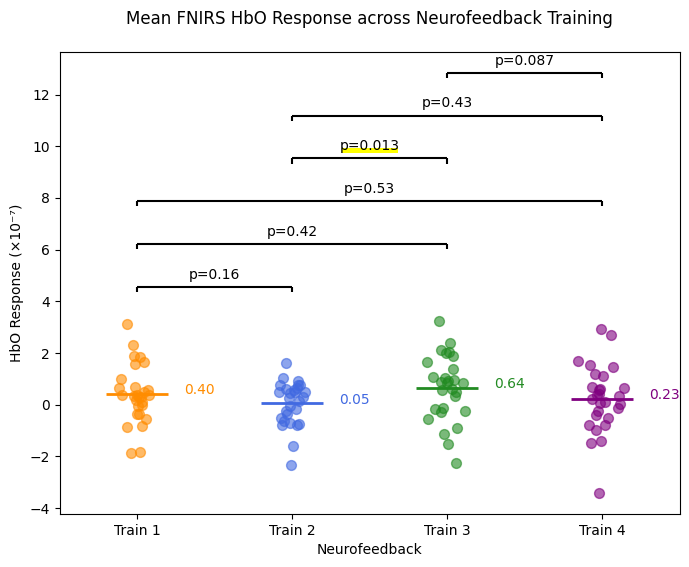

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from itertools import combinations
import matplotlib.patches as patches

# Extract and scale the data (multiply by 10^7 to make values more readable)
train1 = group_epochs_dict['neuro_train_1']['Reappraise_HbO'] * 1e7
train2 = group_epochs_dict['neuro_train_2']['Reappraise_HbO'] * 1e7
train3 = group_epochs_dict['neuro_train_3']['Reappraise_HbO'] * 1e7
train4 = group_epochs_dict['neuro_train_4']['Reappraise_HbO'] * 1e7

training_data = [train1, train2, train3, train4]
training_names = ['Train 1', 'Train 2', 'Train 3', 'Train 4']

# Calculate p-values from paired t-tests
p_values = []
comparisons = []
for (data1, name1), (data2, name2) in combinations(zip(training_data, training_names), 2):
    t_stat, p_val = stats.ttest_rel(data1, data2)
    p_values.append(p_val)
    comparisons.append((name1, name2))

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Add title
plt.title('Mean FNIRS HbO Response across Neurofeedback Training', pad=20)

# Set up the plot parameters with darker colors
x_positions = [1, 2, 3, 4]
colors = ['darkorange', 'royalblue', 'forestgreen', 'purple']

# Calculate means for each training session
means = [np.mean(train) for train in training_data]

# Plot horizontal mean lines and values
for i, (x, mean, color) in enumerate(zip(x_positions, means, colors)):
    ax.hlines(mean, x-0.2, x+0.2, colors=color, linewidth=2)
    ax.text(x+0.3, mean, f'{mean:.2f}', color=color)

# Plot individual data points
for i, (x, train_data, color) in enumerate(zip(x_positions, training_data, colors)):
    # Create a small jitter for x-positions to avoid overlap
    x_jitter = np.random.normal(0, 0.05, size=len(train_data))
    ax.scatter(x + x_jitter, train_data, color=color, alpha=0.6, s=50)

# Function to format p-value with 2 significant figures
def format_pvalue(p_value):
    if p_value < 0.001:
        return f"p<0.001"
    # Convert to string in scientific notation with 1 decimal place (2 sig figs)
    p_str = f"{p_value:.1e}"
    # Split into base and exponent
    base, exponent = p_str.split('e')
    # Convert back to decimal notation
    p_formatted = float(base) * 10**float(exponent)
    # Format to ensure 2 significant figures
    if p_formatted < 0.01:
        return f"p={p_formatted:.2e}"
    elif p_formatted < 0.1:
        return f"p={p_formatted:.3f}"
    else:
        return f"p={p_formatted:.2f}"

# Add significance brackets
def add_significance_bracket(x1, x2, y, p_value):
    ax.hlines(y, x1, x2, color='black')
    ax.vlines([x1, x2], y-0.2, y, color='black')
    p_text = format_pvalue(p_value)
    text = ax.text((x1+x2)/2, y+0.2, p_text, ha='center', va='bottom')

    # Add yellow background for significant p-values
    if p_value < 0.05:
        # Get the bounding box of the text
        bbox = text.get_window_extent(renderer=fig.canvas.get_renderer())
        # Transform from display to data coordinates
        bbox_data = bbox.transformed(ax.transData.inverted())
        # Create a rectangle patch with yellow background
        rect = patches.Rectangle((bbox_data.x0, bbox_data.y0),
                               bbox_data.width, bbox_data.height,
                               facecolor='yellow',
                               alpha=1.0,
                               transform=ax.transData)
        # Add the rectangle patch to the plot
        ax.add_patch(rect)
        # Bring text to front
        text.set_zorder(rect.get_zorder() + 1)

# Calculate appropriate y-positions for brackets based on data range
data_max = max([np.max(train) for train in training_data])
data_min = min([np.min(train) for train in training_data])
data_range = data_max - data_min

# Increase spacing between brackets
bracket_start = data_max + data_range*0.2
bracket_spacing = data_range*0.25  # Increased spacing between brackets
bracket_heights = [bracket_start + i*bracket_spacing for i in range(len(comparisons))]

# Add brackets for each comparison using calculated p-values
for (name1, name2), p_val, y_pos in zip(comparisons, p_values, bracket_heights):
    x1 = training_names.index(name1) + 1
    x2 = training_names.index(name2) + 1
    add_significance_bracket(x1, x2, y_pos, p_val)

# Customize the plot
ax.set_xlim(0.5, 4.5)
ax.set_xticks(x_positions)
ax.set_xticklabels(training_names)
ax.set_ylabel('HbO Response (×10⁻⁷)')
ax.set_xlabel('Neurofeedback')

# Add gridlines an

## Run a more simple t-test, diving the data into run 1+2 vs run 3+4

In [ ]:
from scipy import stats
import numpy as np

# Extract data from each training session
train1 = group_epochs_dict['neuro_train_1']['Reappraise_HbO']
train2 = group_epochs_dict['neuro_train_2']['Reappraise_HbO']
train3 = group_epochs_dict['neuro_train_3']['Reappraise_HbO']
train4 = group_epochs_dict['neuro_train_4']['Reappraise_HbO']

# Calculate means for early (1+2) and late (3+4) sessions for each subject
early_sessions = (train1 + train2) / 2
late_sessions = (train3 + train4) / 2

# Perform paired t-test
t_stat, p_val = stats.ttest_rel(early_sessions, late_sessions)

print("Paired t-test results:")
print(f"Early (1+2) vs Late (3+4) sessions:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_val:.4f}")

# Optional: Calculate mean and std for each group
print("\nDescriptive Statistics:")
print(f"Early sessions mean: {np.mean(early_sessions):.2e}")
print(f"Early sessions std: {np.std(early_sessions):.2e}")
print(f"Late sessions mean: {np.mean(late_sessions):.2e}")
print(f"Late sessions std: {np.std(late_sessions):.2e}")

Paired t-test results:
Early (1+2) vs Late (3+4) sessions:
t-statistic: -1.1190
p-value: 0.2730

Descriptive Statistics:
Early sessions mean: 2.24e-08
Early sessions std: 7.49e-08
Late sessions mean: 4.38e-08
Late sessions std: 1.09e-07


## Visualize the t-test

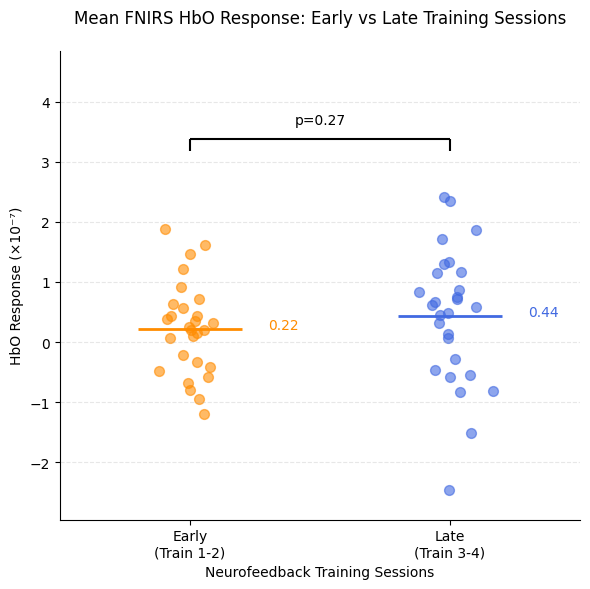

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib.patches as patches

# Calculate means for early (1+2) and late (3+4) sessions for each subject
early_sessions = (train1 + train2) / 2
late_sessions = (train3 + train4) / 2

# Scale the data (multiply by 10^7 to make values more readable)
early_sessions = early_sessions * 1e7
late_sessions = late_sessions * 1e7

# Perform paired t-test
t_stat, p_val = stats.ttest_rel(early_sessions, late_sessions)

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Add title
plt.title('Mean FNIRS HbO Response: Early vs Late Training Sessions', pad=20)

# Set up the plot parameters
x_positions = [1, 2]
colors = ['darkorange', 'royalblue']
names = ['Early\n(Train 1-2)', 'Late\n(Train 3-4)']

# Calculate means
means = [np.mean(early_sessions), np.mean(late_sessions)]
data = [early_sessions, late_sessions]

# Plot horizontal mean lines and values
for i, (x, mean, color) in enumerate(zip(x_positions, means, colors)):
    ax.hlines(mean, x-0.2, x+0.2, colors=color, linewidth=2)
    ax.text(x+0.3, mean, f'{mean:.2f}', color=color)

# Plot individual data points
for i, (x, session_data, color) in enumerate(zip(x_positions, data, colors)):
    # Create a small jitter for x-positions to avoid overlap
    x_jitter = np.random.normal(0, 0.05, size=len(session_data))
    ax.scatter(x + x_jitter, session_data, color=color, alpha=0.6, s=50)

# Function to format p-value with 2 significant figures
def format_pvalue(p_value):
    if p_value < 0.001:
        return f"p<0.001"
    # Convert to string in scientific notation with 1 decimal place (2 sig figs)
    p_str = f"{p_value:.1e}"
    # Split into base and exponent
    base, exponent = p_str.split('e')
    # Convert back to decimal notation
    p_formatted = float(base) * 10**float(exponent)
    # Format to ensure 2 significant figures
    if p_formatted < 0.01:
        return f"p={p_formatted:.2e}"
    elif p_formatted < 0.1:
        return f"p={p_formatted:.3f}"
    else:
        return f"p={p_formatted:.2f}"

# Calculate appropriate y-positions for bracket based on data range
data_max = max(np.max(early_sessions), np.max(late_sessions))
data_min = min(np.min(early_sessions), np.min(late_sessions))
data_range = data_max - data_min

# Add significance bracket
def add_significance_bracket(x1, x2, y, p_value):
    ax.hlines(y, x1, x2, color='black')
    ax.vlines([x1, x2], y-0.2, y, color='black')
    p_text = format_pvalue(p_value)
    text = ax.text((x1+x2)/2, y+0.2, p_text, ha='center', va='bottom')

    # Add yellow background for significant p-values
    if p_value < 0.05:
        # Get the bounding box of the text
        bbox = text.get_window_extent(renderer=fig.canvas.get_renderer())
        # Transform from display to data coordinates
        bbox_data = bbox.transformed(ax.transData.inverted())
        # Create a rectangle patch with yellow background
        rect = patches.Rectangle((bbox_data.x0, bbox_data.y0),
                               bbox_data.width, bbox_data.height,
                               facecolor='yellow',
                               alpha=1,
                               transform=ax.transData)
        # Add the rectangle patch to the plot
        ax.add_patch(rect)
        # Bring text to front
        text.set_zorder(rect.get_zorder() + 1)

# Add bracket
bracket_height = data_max + data_range*0.2
add_significance_bracket(1, 2, bracket_height, p_val)

# Customize the plot
ax.set_xlim(0.5, 2.5)
ax.set_xticks(x_positions)
ax.set_xticklabels(names)
ax.set_ylabel('HbO Response (×10⁻⁷)')
ax.set_xlabel('Neurofeedback Training Sessions')

# Add gridlines and remove top and right spines
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set y-limits
y_min = data_min - data_range*0.1
y_max = bracket_height + data_range*0.3
ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()